# **Project Title: Climate-Resilient Urban Planning – Heat Island Detection and Cooling Infrastructure Mapping for Pune City**

# Phase 1 – : Urban Heat Detection using Landsat 9 (30m) LST
1. Setup and Initialization
2. Define Area of Interest (Pune)
3. Fetch Landsat 9 ST Imagery (Mar–May 2024)
4. Preprocess: Filter Clouds and Scale LST
5. Visualize Mean LST
6. Calculate and Print LST Stats
7. (Optional) Export Map and Stats

In [1]:
# Install and Import Required Libraries
!pip install leafmap numpy matplotlib geopandas rasterio folium shapely geemap osmnx --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 842.5/842.5

### Extract and Save Pune Boundary using OpenStreetMap

In [4]:
# Import libraries
import pandas as pd
import osmnx as ox
import geopandas as gpd
import leafmap.foliumap as leafmap

# Download Pune city boundary from OSM
pune_boundary = ox.geocode_to_gdf("Pune, India")

# Save to GeoJSON
pune_boundary.to_file("/content/drive/MyDrive/urban-heat-dashboard/data/pune_boundary.geojson", driver="GeoJSON")

# Load the saved Pune boundary GeoJSON
# pune_boundary_path = "/content/drive/MyDrive/urban-heat-dashboard/data/pune_boundary.geojson"
# pune_gdf = gpd.read_file(pune_boundary_path)

# # Create a Leafmap interactive map
# m = leafmap.Map(center=[pune_gdf.geometry.centroid.y.mean(), pune_gdf.geometry.centroid.x.mean()], zoom=10)

# # Add the Pune boundary to the map
# m.add_gdf(pune_gdf, layer_name="Pune Boundary")

# # Display the map
# m


### Initialize Earth Engine and Load Pune Boundary

In [5]:
#  # Authenticate and initialize Earth Engine
import ee
import geemap

ee.Authenticate()   # <-- This will give a URL. Click, login, copy-paste token

# Initialize Earth Engine with your Google Cloud Project ID
# Replace 'your-google-cloud-project-id' with your actual project ID
try:
    ee.Initialize(project='ee-prachisarode95')
except ee.EEException as e:
    print(f"Earth Engine initialization failed: {e}")

# Load Pune GeoJSON and convert to EE object
gdf = gpd.read_file("/content/drive/MyDrive/urban-heat-dashboard/data/pune_boundary.geojson")
aoi = geemap.geopandas_to_ee(gdf)

# Center map
Map = geemap.Map(center=[18.52, 73.85], zoom=11)
Map.addLayer(aoi, {}, "Pune Boundary")
Map



Map(center=[18.52, 73.85], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

### Load and Preprocess Landsat 9 Imagery (LST Proxy using Band 10)
Landsat 9 doesn't provide direct LST. We'll use Thermal Band 10 as a proxy and normalize it.

In [6]:
# Load Landsat 9 Collection for March to May 2024
collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filterDate('2024-03-01', '2024-05-31') \
    .filterBounds(aoi) \
    .filter(ee.Filter.lt('CLOUD_COVER', 5)) \
    .select('ST_B10')  # Thermal band (scaled)

# Preprocess: scale thermal band (from metadata: scale = 0.00341802, offset = 149.0)
# Convert Band 10 to Celsius
def scale_to_celsius(img):
    kelvin = img.multiply(0.00341802).add(149)
    celsius = kelvin.subtract(273.15)
    return celsius.copyProperties(img, ["system:time_start"])

thermal_celsius = collection.map(scale_to_celsius)
lst_celsius_mean = thermal_celsius.mean().clip(aoi)


### Visualize Thermal Proxy (LST Approximation)

In [ ]:
vis_params_celsius = {
    'min': 20,  # adjust if needed
    'max': 45,
    'palette': ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']
}

Map.addLayer(lst_celsius_mean, vis_params_celsius, "Mean LST (°C) Mar–May 2024")
Map


Map(bottom=234896.0, center=[18.581172296837025, 73.9479446411133], controls=(WidgetControl(options=['position…

### Calculate and Print Stats

In [ ]:
stats = lst_celsius_mean.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=aoi.geometry(),
    scale=30,
    bestEffort=True
)

print("Average Land Surface Temperature (°C):", stats.getInfo())

Average Land Surface Temperature (°C): {'ST_B10': 42.89556579189361}


### Export LST layer in `Celsius`.

In [ ]:
geemap.ee_export_image(
    lst_celsius_mean,
    filename='/content/drive/MyDrive/urban-heat-dashboard/assets/pune_LST_Celsius.tif',
    scale=30,
    region=aoi.geometry(),
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/urban-heat-dashboard/assets/pune_LST_Celsius.tif


# Phase 2 – Cooling Infrastructure Mapping
**Goal**:
Identify and visualize urban cooling infrastructure features using satellite imagery and OpenStreetMap data, aligned with your LST layer from Phase 1.

**Steps**:
- Extract and visualize green spaces (parks, gardens) and water bodies from OpenStreetMap for Pune.
- Extract NDVI from Landsat 9 to identify urban vegetation cover.
- Overlay cooling infrastructure (green + blue spaces) with LST map from Phase 1.
- Export results for further analysis or dashboarding.


### Step 1: Extract Parks, Gardens, Water Bodies from OSM

<Axes: >

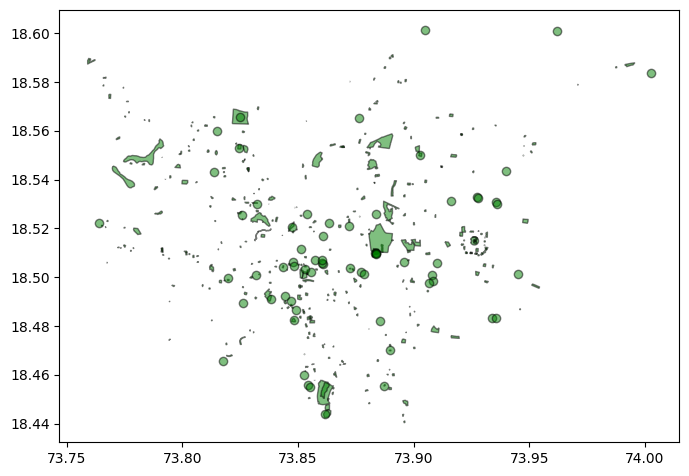

In [10]:
import osmnx as ox
import geopandas as gpd

# Load Pune boundary GeoDataFrame
pune_gdf = gpd.read_file("/content/drive/MyDrive/urban-heat-dashboard/data/pune_boundary.geojson")
pune_polygon = pune_gdf.geometry.unary_union  # Combine geometries if needed

# Define tags for green spaces (parks, gardens, etc.)
tags_green = {
    'leisure': ['park', 'garden', 'golf_course', 'recreation_ground']
}

# Define tags for water bodies
tags_water = {
    'natural': ['water', 'wetland'],
    'water': ['river', 'lake', 'pond']
}

# Download features from OpenStreetMap
green_spaces = ox.features_from_polygon(pune_polygon, tags_green)
water_bodies = ox.features_from_polygon(pune_polygon, tags_water)

# Save to GeoJSON
green_spaces.to_file("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_green_spaces.geojson", driver="GeoJSON")
water_bodies.to_file("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_water_bodies.geojson", driver="GeoJSON")

# Optional: visualize the result
green_spaces.plot(figsize=(8, 6), color="green", edgecolor="black", alpha=0.5)


### Step 2 – Calculate NDVI from Landsat 9 Imagery

In [11]:
#  # Authenticate and initialize Earth Engine
import ee
import geemap

ee.Authenticate()   # <-- This will give a URL. Click, login, copy-paste token

# Initialize Earth Engine with your Google Cloud Project ID
# Replace 'your-google-cloud-project-id' with your actual project ID
try:
    ee.Initialize(project='ee-prachisarode95')
except ee.EEException as e:
    print(f"Earth Engine initialization failed: {e}")

# Convert GDF to ee.FeatureCollection
aoi = geemap.geopandas_to_ee(pune_gdf)

# Landsat 9 collection
collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filterDate('2024-03-01', '2024-05-31') \
    .filterBounds(aoi) \
    .filter(ee.Filter.lt('CLOUD_COVER', 5))

# Add NDVI band
def add_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)

ndvi_collection = collection.map(add_ndvi)
ndvi_mean = ndvi_collection.select('NDVI').mean().clip(aoi)


### Step 3 - Upload LST layer manually to colab

In [ ]:
from google.colab import files
import os

# Trigger the file upload dialog
uploaded = files.upload()

# 'uploaded' is a dictionary where keys are filenames and values are their content
# Iterate through uploaded files
for filename in uploaded.keys():
    print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

# The file will be saved in the current working directory in Colab (usually /content)
# You can now read or process the uploaded file, for example:
# Assuming you uploaded 'lst.tif'
uploaded_file_path = '/content/drive/MyDrive/urban-heat-dashboard/assets/pune_LST_Celsius.tif'
if os.path.exists(uploaded_file_path):
    print(f"File '{uploaded_file_path}' uploaded successfully and is ready to use.")
else:
    print(f"Error: File '{uploaded_file_path}' was not found after upload.")

# You can then use rasterio or other libraries to open and process the file
import rasterio
try:
    with rasterio.open(uploaded_file_path) as src:
        print(f"File '{uploaded_file_path}' opened with rasterio.")
        # Further processing with the rasterio dataset object 'src'
except Exception as e:
    print(f"Error opening file with rasterio: {e}")


Saving pune_LST_Celsius.tif to pune_LST_Celsius (3).tif
User uploaded file "pune_LST_Celsius (3).tif" with length 4006353 bytes
File '/content/drive/MyDrive/urban-heat-dashboard/assets/pune_LST_Celsius.tif' uploaded successfully and is ready to use.
File '/content/drive/MyDrive/urban-heat-dashboard/assets/pune_LST_Celsius.tif' opened with rasterio.


### Step 4 – Visualize NDVI, Green Spaces, Water Bodies & Overlay LST

In [ ]:
# prompt: help me build code for step 4 - Visualize NDVI, Green Spaces, Water Bodies & Overlay LST, using above code snippets

import pandas as pd

# Visualize NDVI & LST
ndvi_vis_params = {
    'min': 0,
    'max': 0.8,  # Adjust max based on typical NDVI values for the region
    'palette': ['brown', 'white', 'green']
}

lst_celsius_params = {
    'min': 20,  # adjust if needed
    'max': 45,
    'palette': ['blue', 'cyan', 'green', 'yellow', 'orange', 'red']
}

Map = geemap.Map(center=[18.52, 73.85], zoom=11)
Map.addLayer(aoi, {}, "Pune Boundary")
Map.addLayer(ndvi_mean, ndvi_vis_params, "Mean NDVI Mar–May 2024")
Map.addLayer(lst_celsius_mean, lst_celsius_params, "Mean LST (°C) Mar–May 2024")

# Add Green Spaces and Water Bodies from GeoJSON files
# Note: You might need to reload these if the Colab session reset
try:
    green_spaces_gdf = gpd.read_file("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_green_spaces.geojson")
    water_bodies_gdf = gpd.read_file("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_water_bodies.geojson")

    Map.add_gdf(green_spaces_gdf, layer_name="Green Spaces", zoom_to_layer=False, info_mode=None, style={'color': 'green', 'fillOpacity': 0.3})
    Map.add_gdf(water_bodies_gdf, layer_name="Water Bodies", zoom_to_layer=False, info_mode=None, style={'color': 'blue', 'fillOpacity': 0.5})

except Exception as e:
    print(f"Error loading GeoJSON files: {e}")

# Display the map with layers
# Map.add_child(folium.LayerControl())
Map

Map(center=[18.52, 73.85], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

### Step 5 – Export NDVI Raster for GEE Use

In [ ]:
# Export NDVI as GeoTIFF
geemap.ee_export_image(
    ndvi_mean,
    filename='/content/drive/MyDrive/urban-heat-dashboard/assets/pune_NDVI_Mean.tif',
    scale=30,
    region=aoi.geometry()
)


Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/urban-heat-dashboard/assets/pune_NDVI_Mean.tif


# Phase 3 – Analysis and Recommendations
**Goal**: Identify hotspots (UHI zones) and analyze whether they overlap with low-NDVI areas and lack green/blue infrastructure to guide planning.

### Step 1 – Define UHI Threshold and Identify Hotspots

In [7]:
# UHI threshold: top 20% hottest pixels
percentile_80 = lst_celsius_mean.reduceRegion(
    reducer=ee.Reducer.percentile([80]),
    geometry=aoi.geometry(),
    scale=30,
    bestEffort=True
).get('LST_Celsius')

hotspots = lst_celsius_mean.gt(ee.Number(percentile_80)).selfMask()


### Step 2 – Identify Low NDVI (Lack of Vegetation)

In [12]:
# Low NDVI: below 0.3 (tunable)
low_ndvi = ndvi_mean.lt(0.3).selfMask()


### Step 3 – Spatial Join: Hotspots ∩ Low NDVI ∩ Outside Cooling Zones

In [1]:
import geopandas as gpd
import pandas as pd

# Load green and water infrastructure GeoJSONs
green_path = "/content/drive/MyDrive/urban-heat-dashboard/assets/pune_green_spaces.geojson"
water_path = "/content/drive/MyDrive/urban-heat-dashboard/assets/pune_water_bodies.geojson"

green_gdf = gpd.read_file(green_path)
water_gdf = gpd.read_file(water_path)

# STEP 1: Remove null or invalid geometries
green_gdf = green_gdf[green_gdf.is_valid & ~green_gdf.is_empty]
water_gdf = water_gdf[water_gdf.is_valid & ~water_gdf.is_empty]

# STEP 2: Simplify geometries (optional, to reduce complexity)
green_gdf["geometry"] = green_gdf["geometry"].simplify(tolerance=10, preserve_topology=True)
water_gdf["geometry"] = water_gdf["geometry"].simplify(tolerance=10, preserve_topology=True)

# STEP 3: Combine both GeoDataFrames
combined_gdf = pd.concat([green_gdf, water_gdf], ignore_index=True)

# STEP 4: Dissolve into a single multipolygon
cooling_union = combined_gdf.dissolve()

# STEP 5: Reproject to projected CRS (UTM zone 43N for Pune)
cooling_union = cooling_union.to_crs(epsg=32643)  # UTM 43N

# STEP 6: Apply buffer in meters (e.g., 200m)
cooling_buffered = cooling_union.buffer(200)

# STEP 7: Reproject back to WGS84 for saving as GeoJSON
cooling_buffered_wgs84 = gpd.GeoDataFrame(geometry=cooling_buffered, crs="EPSG:32643").to_crs(epsg=4326)

# STEP 8: Save to GeoJSON
cooling_buffered_wgs84.to_file(
    "/content/drive/MyDrive/urban-heat-dashboard/assets/pune_cooling_buffer_200m.geojson",
    driver="GeoJSON"
)

print("✅ Cooling buffer saved successfully in GeoJSON format.")


✅ Cooling buffer saved successfully in GeoJSON format.


### Step 4 – Identify UHI Areas Lacking Cooling Infra (Visualize Critical Zones on Interactive Map)
**Goal**:
Overlay the UHI hotspots (from LST) with the 200m cooling buffer, and find which areas are still hot but outside the buffered zones—i.e., underserved by cooling infrastructure.

In [4]:
# Load Hotspot Raster and Convert to Polygons
# Convert high-temperature LST areas to vector polygons (e.g. values > 35°C)
import rasterio
from rasterio.features import shapes
import geopandas as gpd
import numpy as np
import json
from shapely.geometry import shape

# Load LST raster
with rasterio.open("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_LST_Celsius.tif") as src:
    arr = src.read(1)
    transform = src.transform

# Define threshold for hotspot (e.g. > 35°C)
mask = arr > 35

# Extract shapes
results = (
    {"properties": {"value": v}, "geometry": s}
    for s, v in shapes(arr, mask=mask, transform=transform)
)

# Convert to GeoDataFrame
hotspot_gdf = gpd.GeoDataFrame.from_features(results, crs=src.crs)

# Reproject to EPSG:4326
hotspot_gdf = hotspot_gdf.to_crs(epsg=4326)

# Save as GeoJSON (optional)
hotspot_gdf.to_file("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_hotspots_35C.geojson", driver="GeoJSON")


In [5]:
# Load the 200m Cooling Buffer Layer
cooling_buffer_gdf = gpd.read_file("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_cooling_buffer_200m.geojson")


In [6]:
# Find Hotspots Outside Cooling Buffer
# Ensure same CRS
hotspot_gdf = hotspot_gdf.to_crs(epsg=4326)
cooling_buffer_gdf = cooling_buffer_gdf.to_crs(epsg=4326)

# Perform spatial difference
uhi_without_infra = gpd.overlay(hotspot_gdf, cooling_buffer_gdf, how="difference")

# Save the underserved UHI zones
uhi_without_infra.to_file("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_hotspots_outside_buffer.geojson", driver="GeoJSON")


In [11]:
# import ee
# import geemap
# import geopandas as gpd
# import folium

# # Authenticate and initialize Earth Engine
# ee.Authenticate()
# try:
#     ee.Initialize(project='ee-prachisarode95')
# except ee.EEException as e:
#     print(f"Earth Engine initialization failed: {e}")

# # Create geemap interactive map centered on Pune
# Map = geemap.Map(center=[18.52, 73.85], zoom=11)

# # ---- Load GeoJSON Outputs ----

# # 1. UHI Hotspots (GeoJSON vector)
# hotspots = gpd.read_file("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_hotspots_35C.geojson")
# Map.add_gdf(hotspots, layer_name="🔥 UHI Hotspots", style={"color": "red", "fillOpacity": 0.5})

# # 2. Cooling Infra Buffer (200m)
# cooling_buffer = gpd.read_file("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_cooling_buffer_200m.geojson")
# Map.add_gdf(cooling_buffer, layer_name="🟢 Cooling Infra Buffer", style={"color": "green", "fillOpacity": 0.2})

# # 3. UHI Areas Outside Buffer (Deficit Zones)
# uhi_gap = gpd.read_file("/content/drive/MyDrive/urban-heat-dashboard/assets/pune_hotspots_outside_buffer.geojson")
# Map.add_gdf(uhi_gap, layer_name="⚠️ Underserved UHI Areas", style={"color": "orange", "fillOpacity": 0.4})

# # Optional: Add Pune boundary for context
# # Map.add_geojson("path_to_pune_boundary.geojson", layer_name="Pune Boundary")

# # Add layer control and show the map
# Map.add_child(folium.LayerControl())
# Map


In [12]:
# Basic Stats
print("Total hotspot polygons:", len(hotspot_gdf))
print("Hotspot polygons outside cooling buffer:", len(uhi_without_infra))
uhi_without_infra["area_ha"] = uhi_without_infra.geometry.area * 10000  # if in degrees, consider reprojecting before
print("Total underserved area (approx):", uhi_without_infra["area_ha"].sum(), "sq meters")


Total hotspot polygons: 663762
Hotspot polygons outside cooling buffer: 578143
Total underserved area (approx): 438.7066946844716 sq meters


### Step 5 – Recommendations Summary
Create a summary that highlights:

Zones with high LST, low NDVI, and no proximity to cooling features.

Priority areas for adding green infrastructure.

Suggest use of rooftop gardens, parks, water ponds in underserved wards.

In [13]:
print("🧾 Recommendations:")
print("- Prioritize hotspots with low vegetation and no nearby cooling infra.")
print("- Consider green corridors along roads and water-sensitive urban design.")
print("- Deploy tree-planting or water-body restoration campaigns in these wards.")


🧾 Recommendations:
- Prioritize hotspots with low vegetation and no nearby cooling infra.
- Consider green corridors along roads and water-sensitive urban design.
- Deploy tree-planting or water-body restoration campaigns in these wards.
